# Samsung Stock Prediction

#  Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')




In [ ]:
df = pd.read_csv("/content/Samsung Dataset.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.859863,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.098145,46880000


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6122,2024-06-07,78400.0,78600.0,77100.0,77300.0,77300.0,21189349
6123,2024-06-10,76100.0,76600.0,75600.0,75700.0,75700.0,14598755
6124,2024-06-11,75900.0,76000.0,75100.0,75200.0,75200.0,16971175
6125,2024-06-12,75300.0,77100.0,75200.0,76500.0,76500.0,19246725
6126,2024-06-13,78400.0,79000.0,77800.0,78600.0,78600.0,33763804


# EDA

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)

In [ ]:
start_date = '2023-06-01'
end_date = '2024-06-13'
df = df[(df.index >= start_date) & (df.index <= end_date)][['Close']]

In [ ]:
df= df[["Close"]]

In [ ]:
df.head()

,Close
Date,
2023-06-01,70900.0
2023-06-02,72200.0
2023-06-05,71700.0
2023-06-07,71000.0
2023-06-08,70900.0


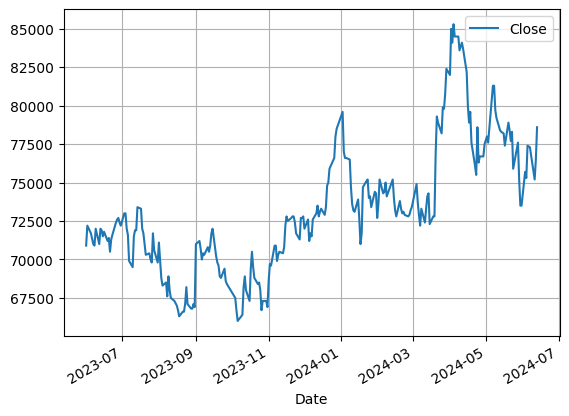

In [ ]:
df.plot()
plt.grid(True)

In [ ]:
# Test for stationarity
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(100).mean()
    rolstd = timeseries.rolling(100).std()

    # Plot rolling statistics
    plt.figure(figsize=(18, 8))
    plt.grid(True)
    plt.plot(timeseries, color='blue', label='Original', linewidth=3)
    plt.plot(rolmean, color='red', label='Rolling mean', linewidth=3)
    plt.plot(rolstd, color='black', label='Rolling std', linewidth=3)
    plt.legend(loc='best', fontsize=20, shadow=True, facecolor='lightpink')
    plt.title('Rolling mean and std', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show(block=False)

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag="AIC")
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'Lags', 'Observations'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)


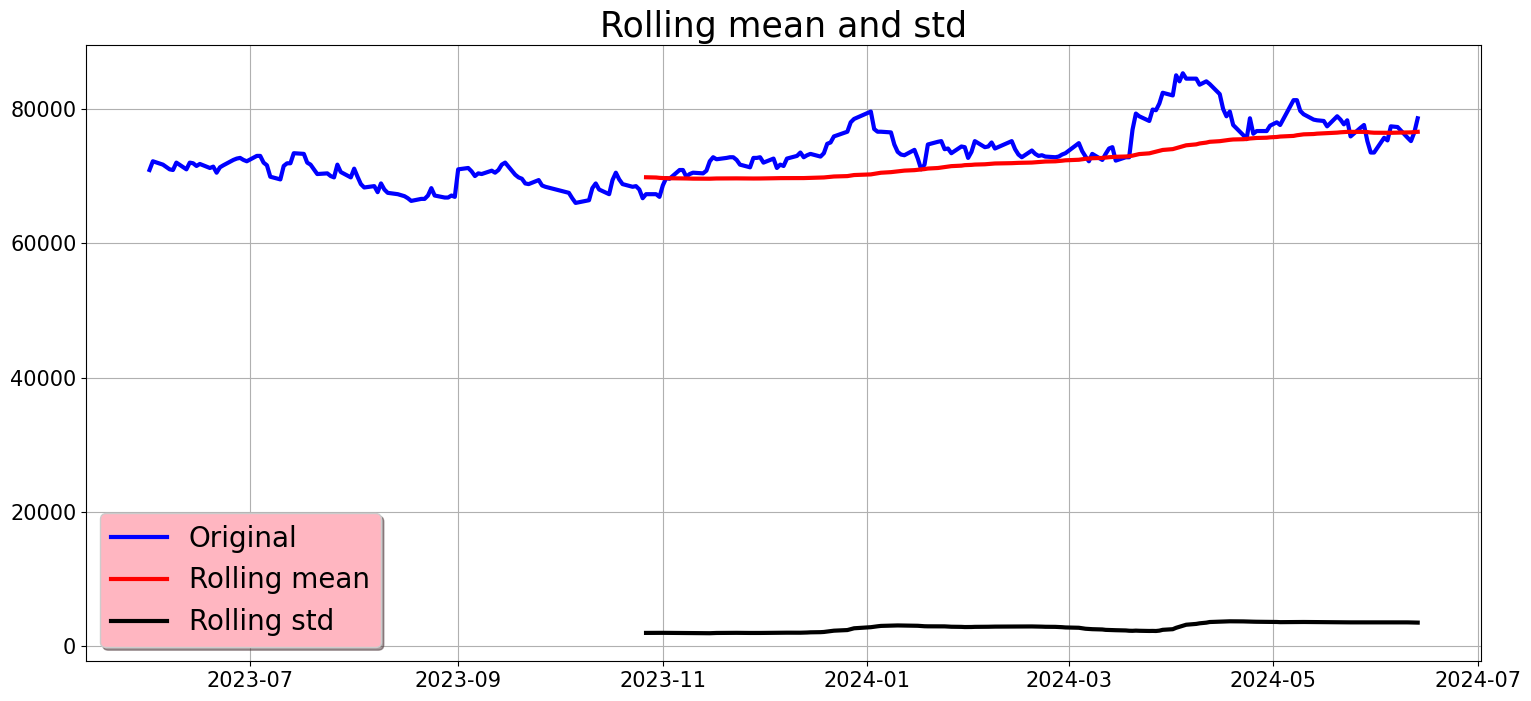

Results of Dickey-Fuller Test:
Test Statistics          -1.905541
p-value                   0.329459
Lags                      0.000000
Observations            252.000000
Critical Value (1%)      -3.456569
Critical Value (5%)      -2.873079
Critical Value (10%)     -2.572919
dtype: float64


In [ ]:
test_stationarity(df.Close)

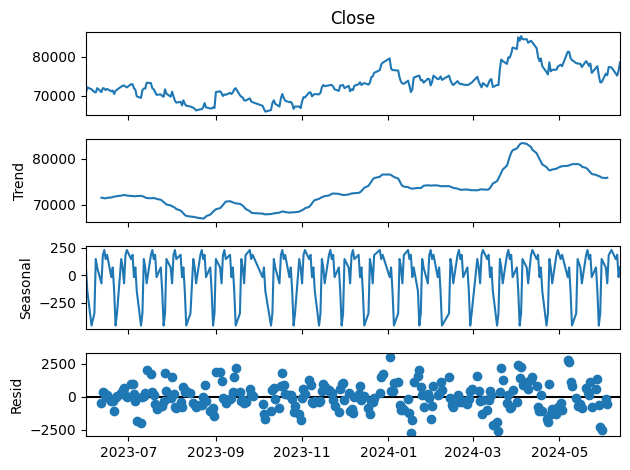

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df' is your DataFrame and 'Close' is your time series column
result = seasonal_decompose(df['Close'], period=12)

# To plot the decomposition
import matplotlib.pyplot as plt

result.plot()
plt.show()


In [ ]:
result.seasonal

,seasonal
Date,
2023-06-01,71.629464
2023-06-02,-143.578869
2023-06-05,-456.078869
2023-06-07,-346.078869
2023-06-08,148.087798
...,...
2024-06-07,229.546131
2024-06-10,147.046131
2024-06-11,186.421131


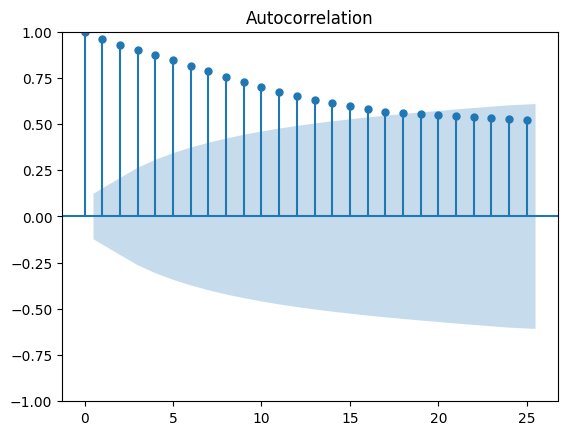

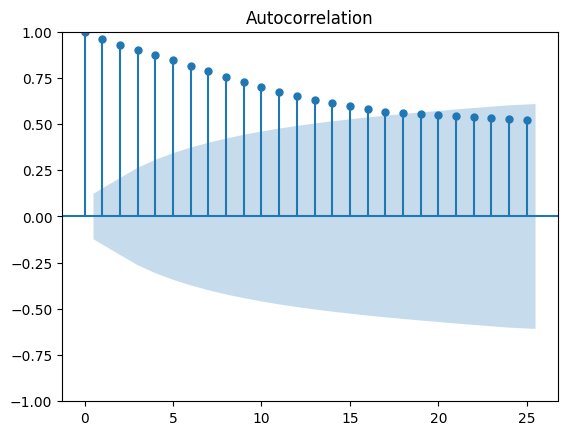

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df.Close)

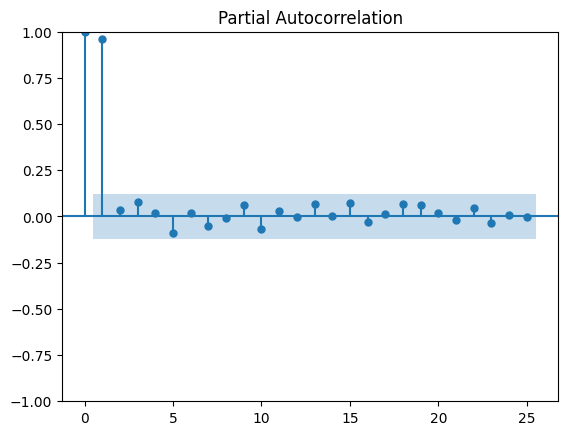

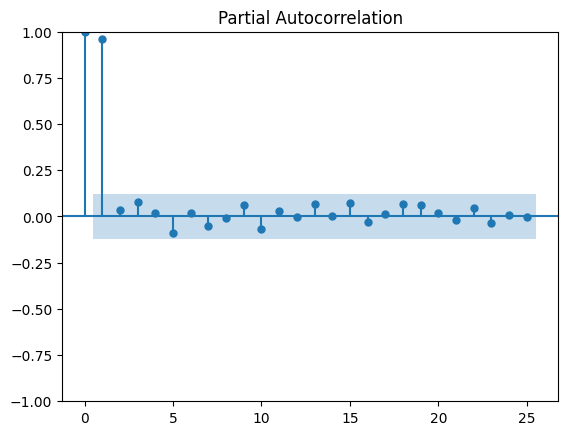

In [ ]:
plot_pacf(df.Close)

In [ ]:
df_stock = df['Close']


In [ ]:
df_close = df_stock.diff()

In [ ]:
df_close = df_close.dropna()

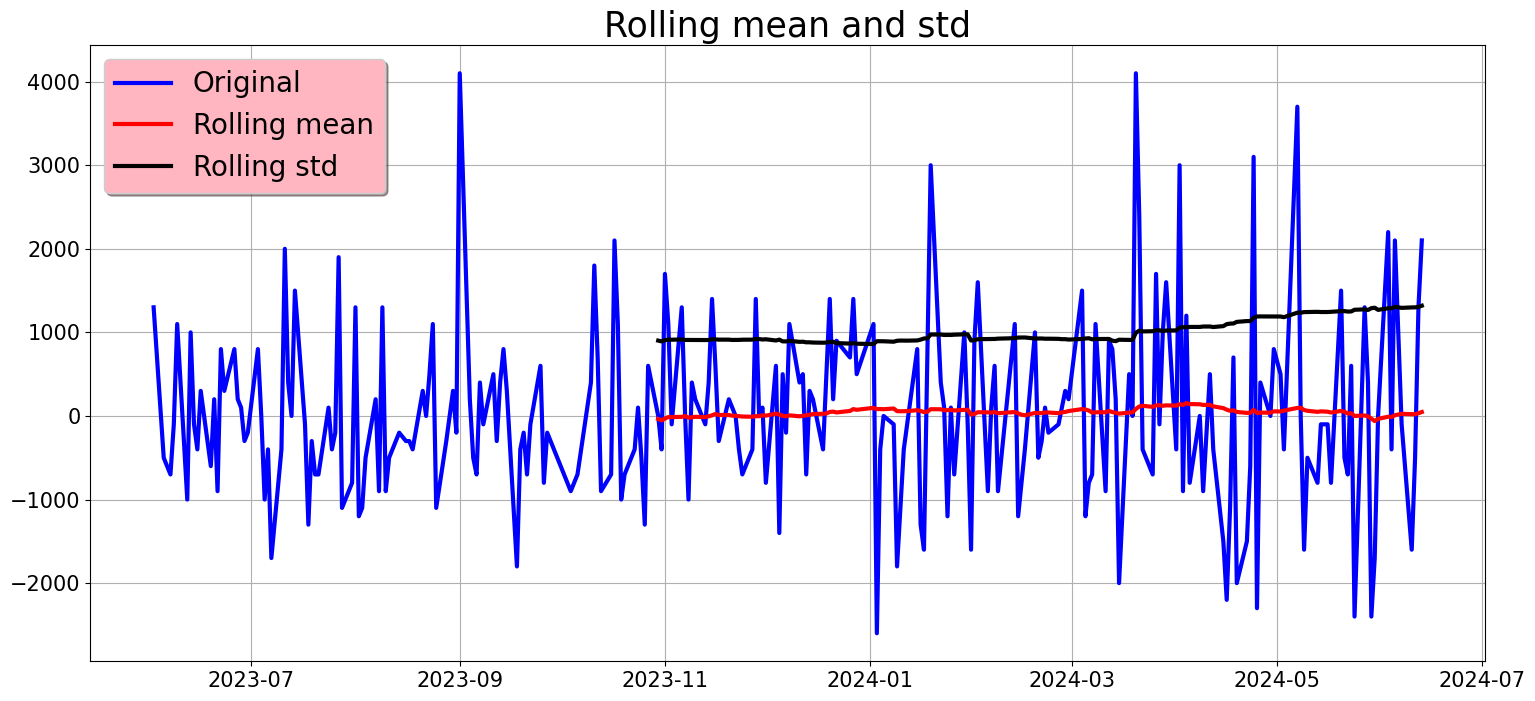

Results of Dickey-Fuller Test:
Test Statistics        -1.589537e+01
p-value                 8.447761e-29
Lags                    0.000000e+00
Observations            2.510000e+02
Critical Value (1%)    -3.456674e+00
Critical Value (5%)    -2.873125e+00
Critical Value (10%)   -2.572944e+00
dtype: float64


In [ ]:
test_stationarity(df_close)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-06-01 to 2024-06-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


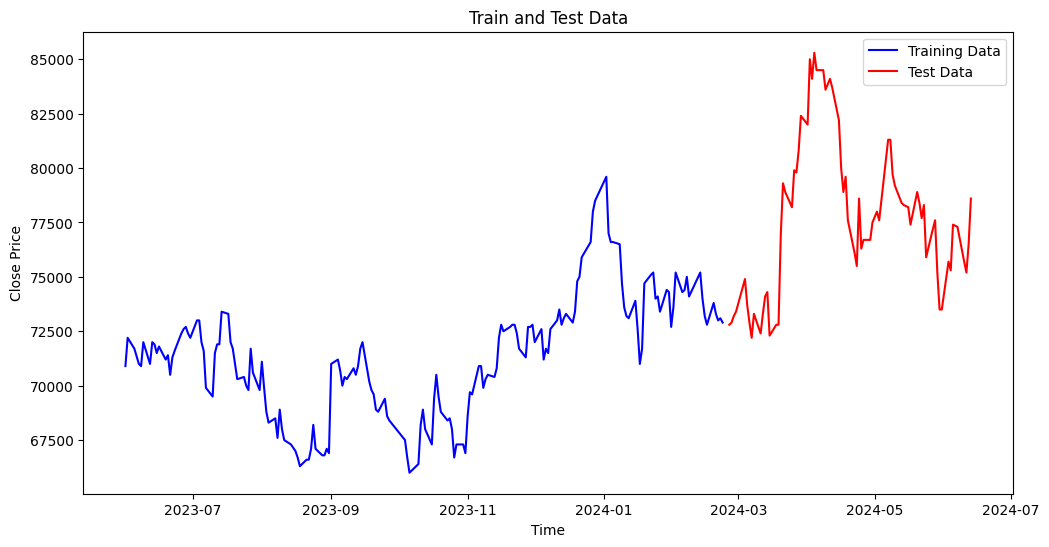

In [ ]:
# Create the train and test sets
train = df[['Close']][:180]
test = df[['Close']][180:]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Test Data', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Train and Test Data')
plt.legend()
plt.show()


In [ ]:
print(len(train), len(test))


180 73


In [ ]:
# Function to find the best ARIMA order based on RMSE and print all tested orders with RMSE
def best_arima_order(train, test, p_values, d_values, q_values):
    best_order = None
    best_rmse = float('inf')
    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(test))
                    rmse = sqrt(mean_squared_error(test, forecast))
                    results.append(((p, d, q), rmse))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                except Exception as e:
                    continue

    print("\nARIMA Results:")
    for order, rmse in results:
        print(f"ARIMA{order} - RMSE: {rmse}")

    return best_order, best_rmse

In [ ]:
# Function to find the best SARIMA order based on RMSE and print all tested orders with RMSE
def best_sarima_order(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    best_order = None
    best_rmse = float('inf')
    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                try:
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.get_forecast(steps=len(test)).predicted_mean
                                    rmse = sqrt(mean_squared_error(test, forecast))
                                    results.append(((p, d, q, P, D, Q, m), rmse))
                                    if rmse < best_rmse:
                                        best_rmse = rmse
                                        best_order = (p, d, q, P, D, Q, m)
                                except Exception as e:
                                    continue

    print("\nSARIMA Results:")
    for order, rmse in results:
        print(f"SARIMA{order} - RMSE: {rmse}")

    return best_order, best_rmse



In [ ]:
# Define ranges for p, d, q for ARIMA and SARIMA
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

In [ ]:
# Seasonal parameters for SARIMA
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
m_values = [12]  # Monthly seasonality

In [ ]:
# Get the best ARIMA order
best_arima_order, best_arima_rmse = best_arima_order(train, test, p_values, d_values, q_values)
print(f"\nBest ARIMA order: {best_arima_order} with RMSE: {best_arima_rmse}")


ARIMA Results:
ARIMA(0, 0, 0) - RMSE: 7233.4578631128525
ARIMA(0, 0, 1) - RMSE: 7232.616116985756
ARIMA(0, 0, 2) - RMSE: 7231.3800539707245
ARIMA(0, 1, 0) - RMSE: 5891.670461076197
ARIMA(0, 1, 1) - RMSE: 5898.055066503867
ARIMA(0, 1, 2) - RMSE: 5895.111218510794
ARIMA(0, 2, 0) - RMSE: 13491.773241701012
ARIMA(0, 2, 1) - RMSE: 12976.877437248122
ARIMA(0, 2, 2) - RMSE: 12640.539553275943
ARIMA(1, 0, 0) - RMSE: 7046.971373794613
ARIMA(1, 0, 1) - RMSE: 7074.372278008468
ARIMA(1, 0, 2) - RMSE: 6997.406970733533
ARIMA(1, 1, 0) - RMSE: 5897.773674014898
ARIMA(1, 1, 1) - RMSE: 5897.016081166102
ARIMA(1, 1, 2) - RMSE: 5887.320275606665
ARIMA(1, 2, 0) - RMSE: 13051.287131000885
ARIMA(1, 2, 1) - RMSE: 11185.902930593858
ARIMA(1, 2, 2) - RMSE: 11326.059220475117
ARIMA(2, 0, 0) - RMSE: 7068.381907944804
ARIMA(2, 0, 1) - RMSE: 7073.346430686697
ARIMA(2, 0, 2) - RMSE: 6983.238410944826
ARIMA(2, 1, 0) - RMSE: 5895.237170241257
ARIMA(2, 1, 1) - RMSE: 5888.400125193631
ARIMA(2, 1, 2) - RMSE: 5889.76063

# Arima Model

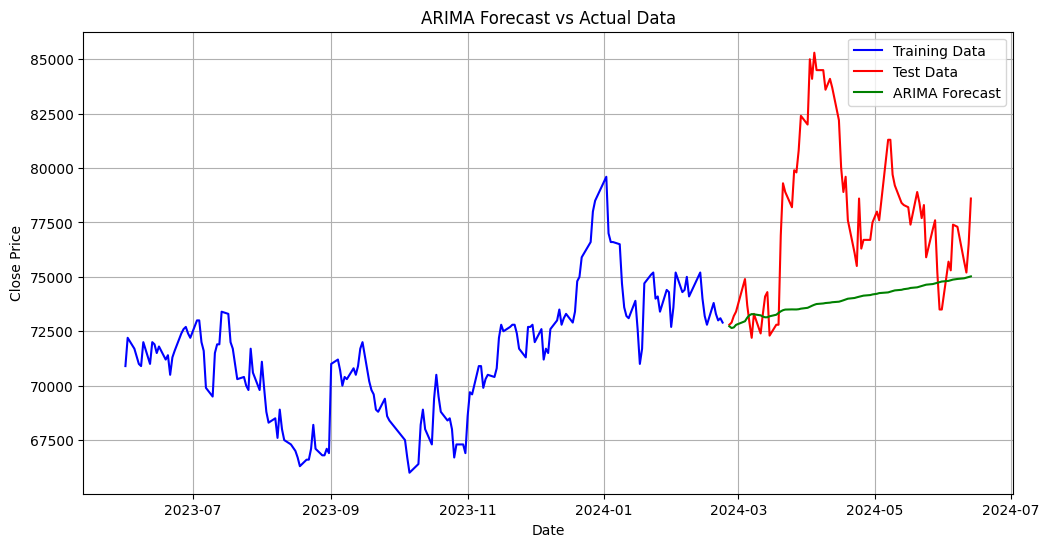

In [ ]:
arima_order = (2, 2, 2)  # ARIMA(p, d, q) order

# Fit ARIMA model
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# Forecast the next 30 days
forecast_steps = len(test)  # Number of steps to forecast (length of test data)
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='red')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast vs Actual Data')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Get the best SARIMA order
best_sarima_order, best_sarima_rmse = best_sarima_order(train,test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values)
print(f"\nBest SARIMA order: {best_sarima_order} with RMSE: {best_sarima_rmse}")


SARIMA Results:
SARIMA(0, 0, 0, 0, 0, 0, 12) - RMSE: 77713.4153895378
SARIMA(0, 0, 0, 0, 0, 1, 12) - RMSE: 73731.00225055902
SARIMA(0, 0, 0, 0, 0, 2, 12) - RMSE: 70286.08304033292
SARIMA(0, 0, 0, 0, 1, 0, 12) - RMSE: 5336.370425211175
SARIMA(0, 0, 0, 0, 1, 1, 12) - RMSE: 5336.703198861044
SARIMA(0, 0, 0, 0, 1, 2, 12) - RMSE: 5334.9258591617945
SARIMA(0, 0, 0, 1, 0, 0, 12) - RMSE: 5466.437276832295
SARIMA(0, 0, 0, 1, 0, 1, 12) - RMSE: 5277.08794006592
SARIMA(0, 0, 0, 1, 0, 2, 12) - RMSE: 5341.591568401605
SARIMA(0, 0, 0, 1, 1, 0, 12) - RMSE: 5336.5952723631135
SARIMA(0, 0, 0, 1, 1, 1, 12) - RMSE: 5337.090729343683
SARIMA(0, 0, 0, 1, 1, 2, 12) - RMSE: 5337.735091926403
SARIMA(0, 0, 0, 2, 0, 0, 12) - RMSE: 5292.591395681561
SARIMA(0, 0, 0, 2, 0, 1, 12) - RMSE: 5280.9501104297915
SARIMA(0, 0, 0, 2, 0, 2, 12) - RMSE: 5206.922854277363
SARIMA(0, 0, 0, 2, 1, 0, 12) - RMSE: 5335.132279444244
SARIMA(0, 0, 0, 2, 1, 1, 12) - RMSE: 5350.034196436926
SARIMA(0, 0, 0, 2, 1, 2, 12) - RMSE: 4922.00190

# Sarima Model

In [ ]:
# 2. Forecast with best SARIMA model
sarima_model = SARIMAX(train, order=best_sarima_order[:3], seasonal_order=best_sarima_order[3:])
sarima_fit = sarima_model.fit(disp=False)



In [ ]:
# Forecast the next days
forecast_steps = len(test)  # Number of steps to forecast (length of test data)
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)


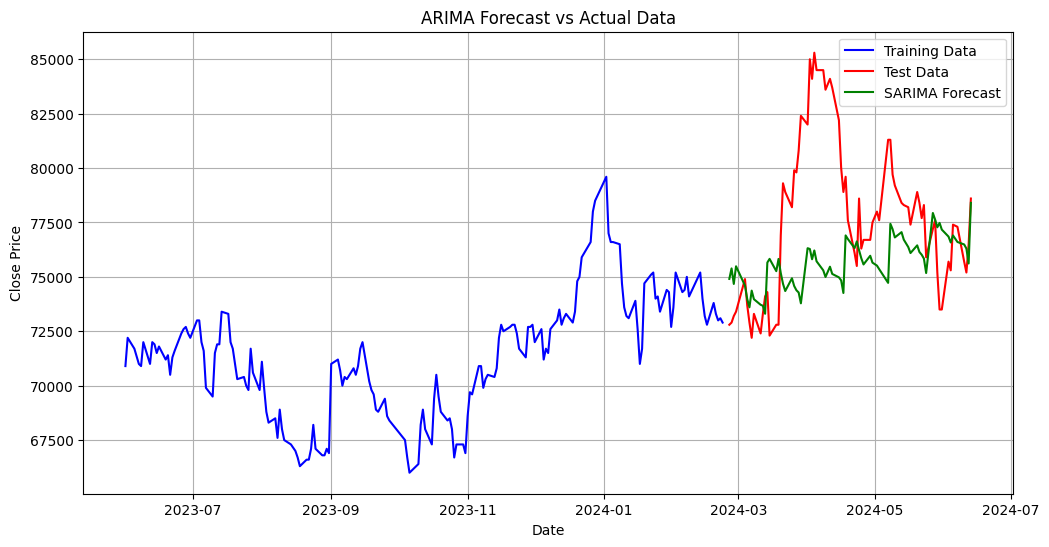

In [ ]:
# Plotting
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast vs Actual Data')
plt.grid(True)
plt.legend()
plt.show()

# Next 30 Days Forecasting

In [ ]:
# Define the future dates for 30 days after the test period
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30, freq='D')


In [ ]:
# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=30)
arima_forecast_mean = arima_forecast.predicted_mean
arima_conf_int = arima_forecast.conf_int()

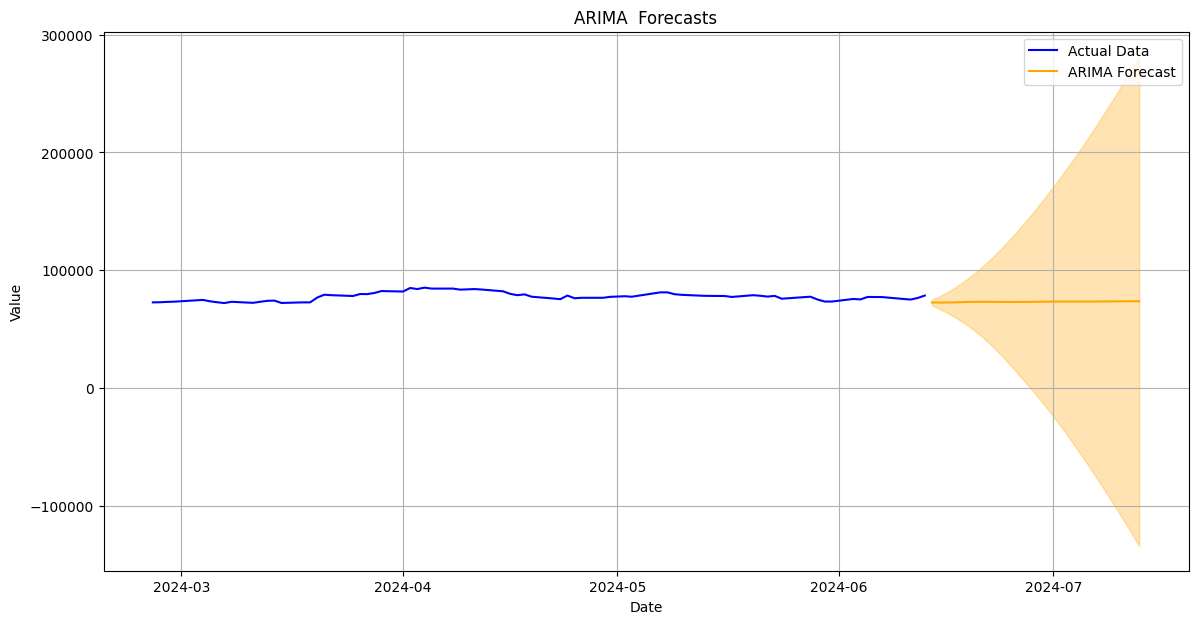

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA  Forecasts')
plt.grid(True)

plt.legend()
plt.show()


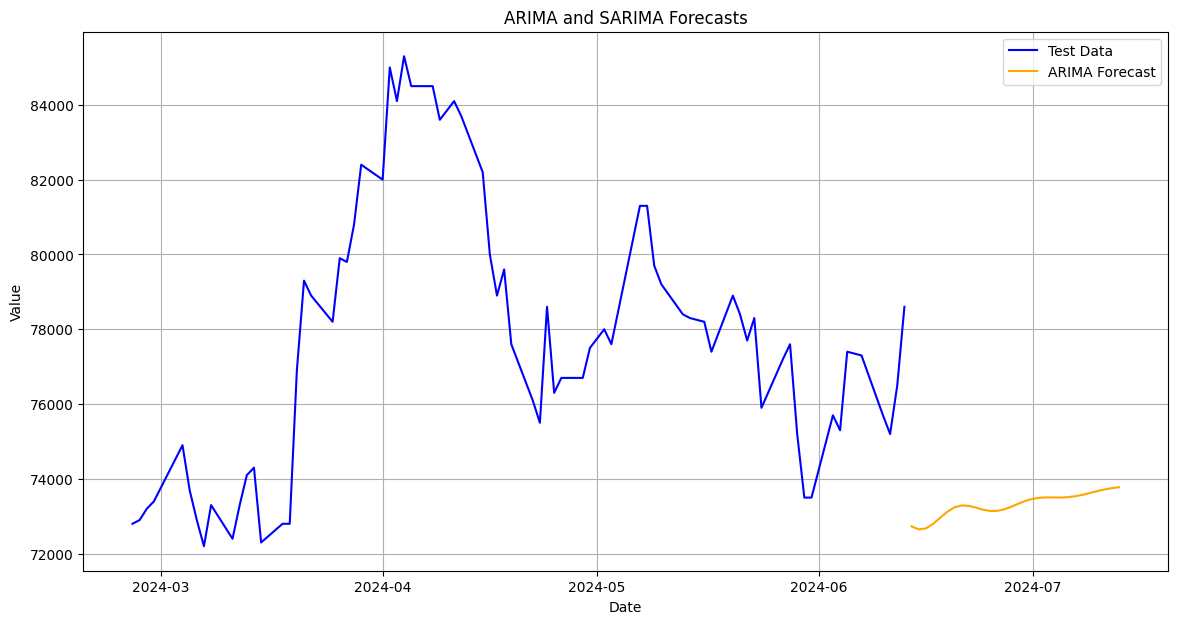

In [ ]:
plt.figure(figsize=(14, 7))

# Plot test data
plt.plot(test, label='Test Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
#plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Forecast with SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=30)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()

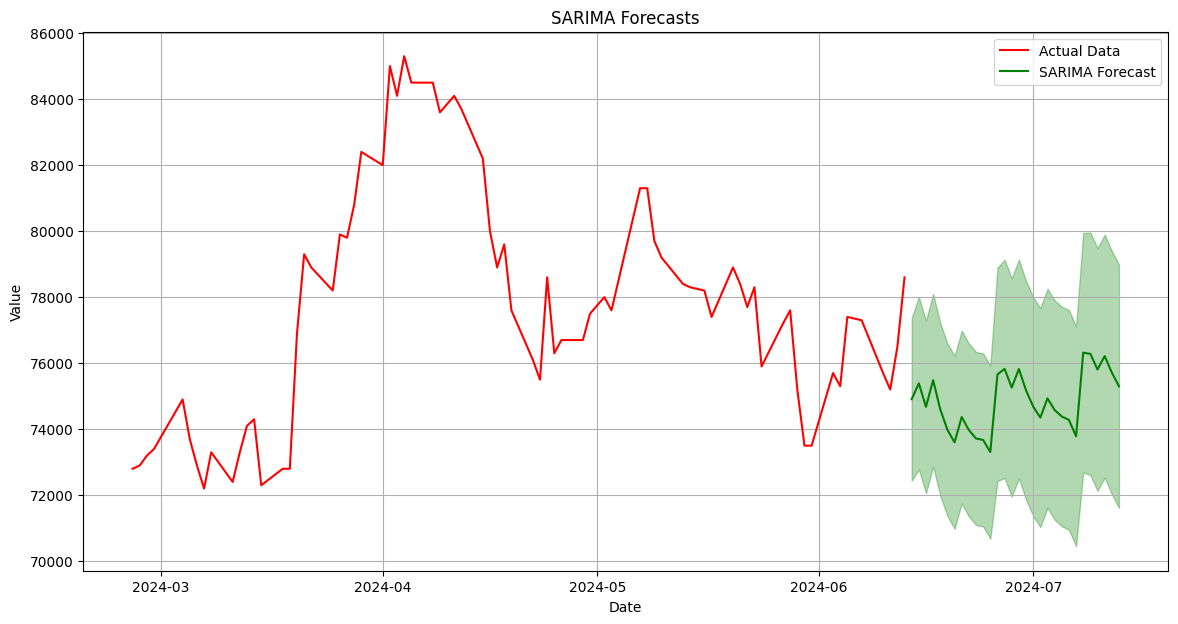

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='red')

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


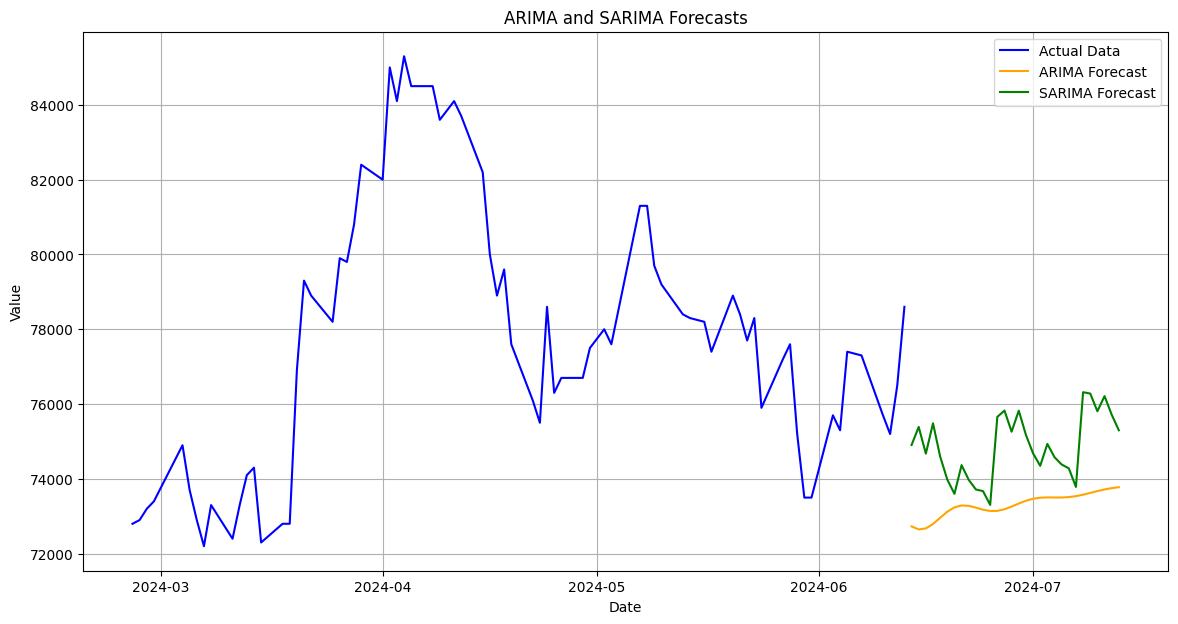

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
#plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
#plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


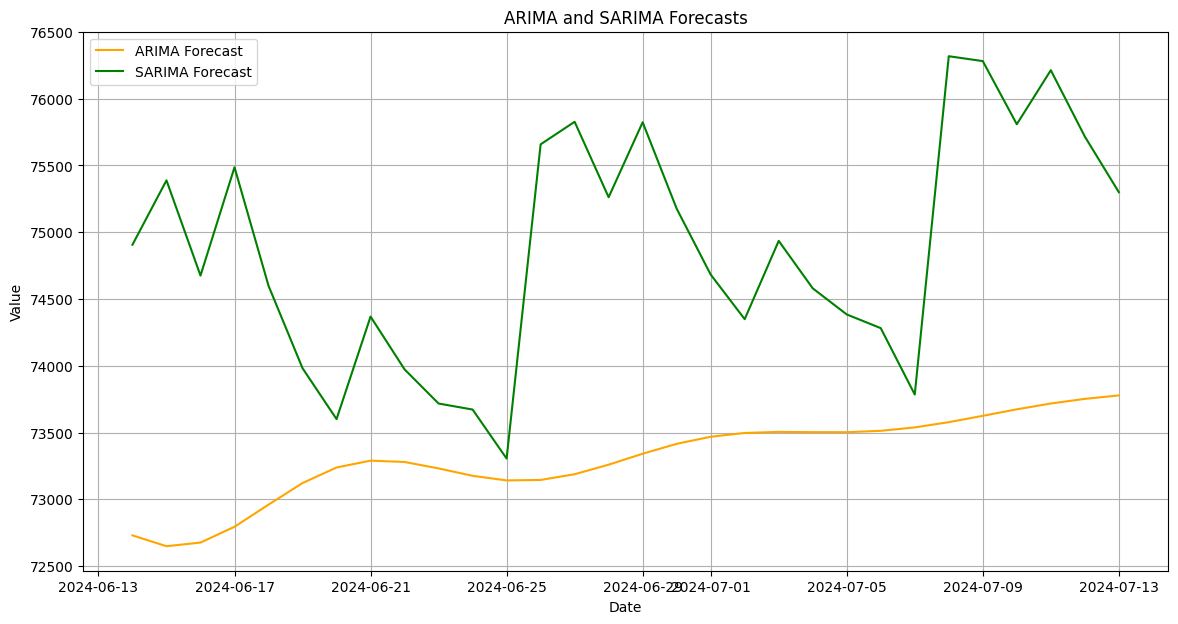

In [ ]:
plt.figure(figsize=(14, 7))

import matplotlib.pyplot as plt

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
#plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.1)  # Adjusted alpha value



# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
#plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()


# Next 90 Days Forecasting

In [ ]:
# Define the future dates for 90 days after the test period
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=90, freq='D')

In [ ]:
# Forecast with ARIMA
arima_forecast = arima_fit.get_forecast(steps=90)
arima_forecast_mean = arima_forecast.predicted_mean
arima_conf_int = arima_forecast.conf_int()

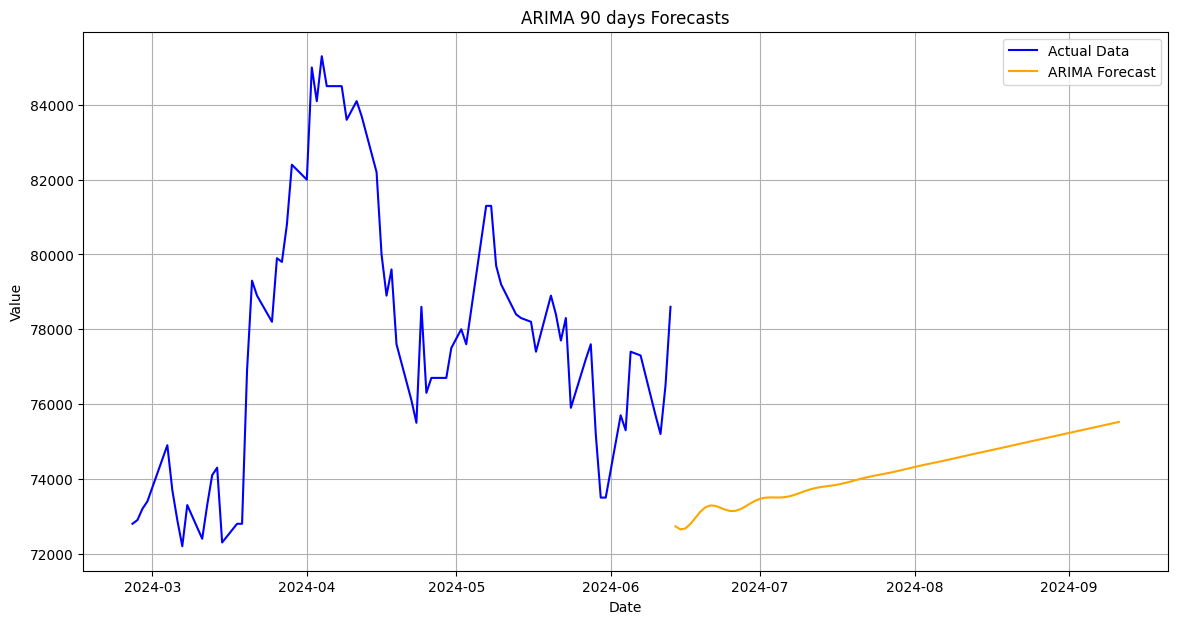

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
#plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA 90 days Forecasts')
plt.grid(True)

plt.legend()
plt.show()


In [ ]:
# Forecast with SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=90)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()

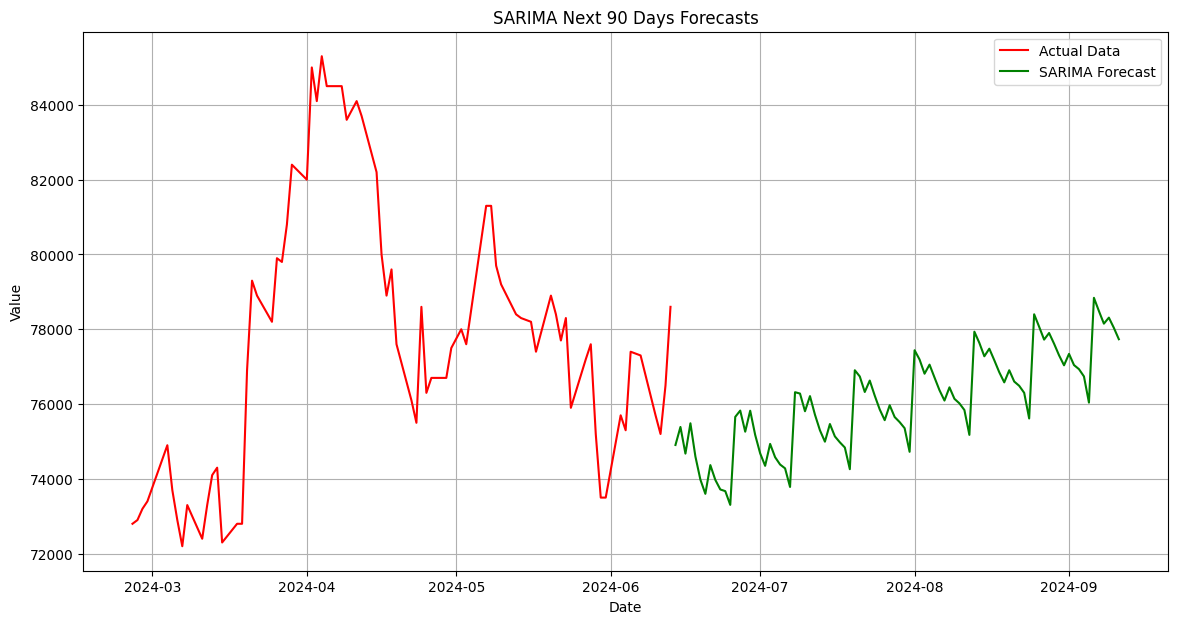

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='red')

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
#plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Next 90 Days Forecasts')
plt.grid(True)
plt.legend()
plt.show()


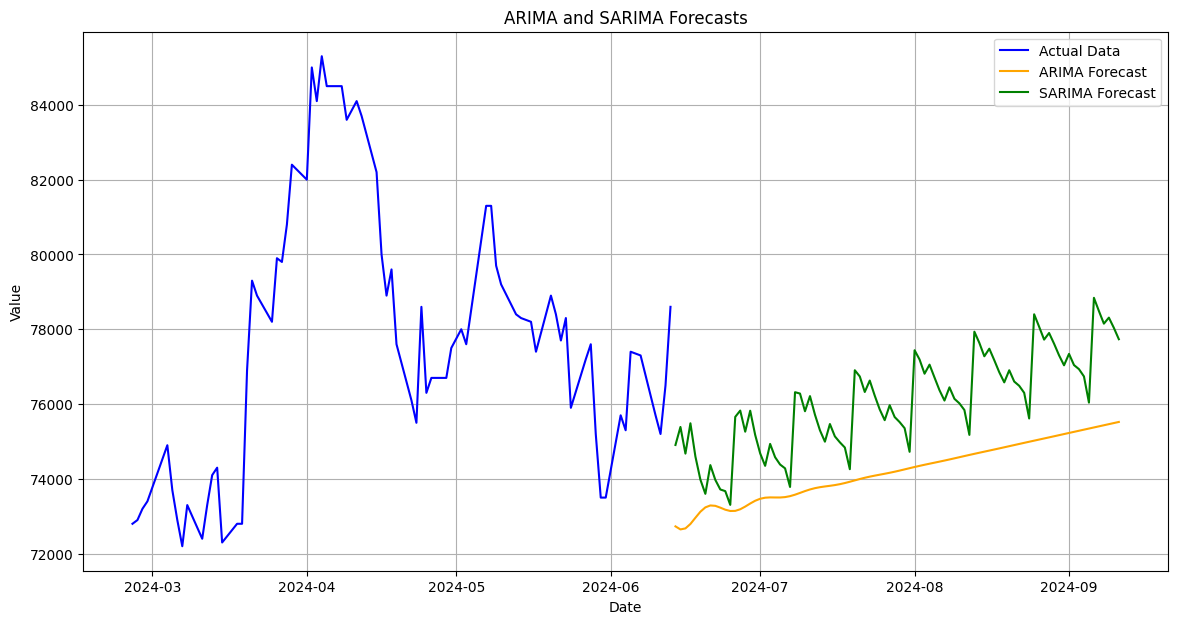

In [ ]:
plt.figure(figsize=(14, 7))

# Plot Actual data
plt.plot(test, label='Actual Data', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_mean, label='ARIMA Forecast', color='orange')
#plt.fill_between(future_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Plot SARIMA forecast
plt.plot(future_dates, sarima_forecast_mean, label='SARIMA Forecast', color='green')
#plt.fill_between(future_dates, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='green', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA and SARIMA Forecasts')
plt.grid(True)
plt.legend()
plt.show()
